In [19]:
%reload_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from webcolors import hex_to_rgb, rgb_to_hex
from colour import HSL_to_RGB
from colorml.utils.utils import pairwise_delta_es, delta_e_deviation
import math

%matplotlib inline

golden_ratio = (5**.5 - 1) / 2

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

RESULTS = '../results/eda/'

In [20]:
def weighted_avg_and_std(values):
    """
    http://www.odelama.com/data-analysis/How-to-Compute-RGB-Image-Standard-Deviation-from-Channels-Statistics/
    """
    r = values[:, 0]
    g = values[:, 1]
    b = values[:, 2]
    
    r_mean = r.mean()
    g_mean = g.mean()
    b_mean = b.mean()
    
    r_var = r.var()
    g_var = g.var()
    b_var = b.var()
    
    avg = 0.299 * r_mean + 0.587 * g_mean + 0.114 * b_mean

    var = 0.299 * r_var + 0.587 * g_var + 0.114 * b_var + (2/3)*(0.299 * r_mean**2 + 0.587 * g_mean ** 2 + 0.114 * b_mean ** 2) - (2/3)*(0.486 * r_mean*g_mean + 0.214*r_mean*b_mean + 0.300*g_mean*b_mean)
            
    return avg, var ** (1/2)

In [21]:
df = pd.read_csv('../data/backup_colorcrawler.csv')

In [22]:
df.head()

color_string      hex                   starttime  \
0   pale green  #05491e  2020-02-10 16:10:09.000000   
1    pale blue  #759eea  2020-02-10 16:10:17.000000   
2  amaranthine  #cc380b  2020-02-10 16:10:25.000000   
3      magenta  #bd18ca  2020-02-10 16:10:45.000000   
4   dark brown  #732e02  2020-02-10 16:11:01.000000   

                   time_stamp  
0  2020-02-10 16:10:17.358811  
1  2020-02-10 16:10:25.771700  
2  2020-02-10 16:10:45.384875  
3  2020-02-10 16:11:01.010912  
4  2020-02-10 16:11:13.608265

In [23]:
# datetimes are saved as strings in our dump, so we convert them back
df['time_stamp'] = pd.to_datetime(df['time_stamp'], infer_datetime_format=True) 
df['starttime'] = pd.to_datetime(df['starttime'], infer_datetime_format=True) 

In [24]:
df['delta_t'] = df['time_stamp'] - df['starttime']

In [25]:
df['delta_t_seconds'] = df['delta_t'].dt.total_seconds()

In [26]:
df["delta_t_seconds"].median()

21.591137000000003

In [27]:
df["delta_t_seconds"].mean()

34.781838626453492

In [28]:
df["delta_t_seconds"].min()

0.7571190000000001

In [29]:
df["delta_t_seconds"].max()

4113.0235210000001

In [30]:
colors_clean = [str(c).replace('-', ' ') for c in df.dropna()['color_string'].unique()]

In [31]:
df['clean_name'] =  [str(c).replace('-', ' ').replace('courless', 'colorless') for c in df['color_string']]

In [32]:
len(df['color_string'].unique())

162

In [33]:
#df = df[~(df['color_string'] == 'courless')]
df.dropna(inplace=True)

In [34]:
def get_rgb_lists(df):
    rs = []
    gs = []
    bs = []
    for i, row in df.iterrows(): 
        r, g, b = hex_to_rgb(row['hex'])
        rs.append(r)
        gs.append(g)
        bs.append(b)

    return rs, gs, bs

rs, gs, bs = get_rgb_lists(df)

df['r'] = rs
df['g'] = gs
df['b'] = bs

In [35]:
standard_deviations = []

for color in df['color_string'].unique():
    df_subset = df[df['color_string'] == color]

    std_rgb = np.std(df_subset[['r', 'g', 'b']].values)
    avg_weighted, std_weighted = weighted_avg_and_std(df_subset[['r', 'g', 'b']].values)
    mean =  np.mean(df_subset[['r', 'g', 'b']].values, axis=0)
    delta_e = delta_e_deviation(df_subset[['r', 'g', 'b']].values, True)
    standard_deviations.append(
        {
            'color_string': color,
            'avg': mean,
            'avg_weighted': avg_weighted,
            'z': std_rgb / np.mean(df_subset[['r', 'g', 'b']].values),
            'std': std_rgb,
            'std_weighted': std_weighted,
            'delta_e': np.mean(delta_e)
        }
    )
df_std = pd.DataFrame(standard_deviations)
#df_merged.dropna(inplace=True)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  if __name__ == '__main__':
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


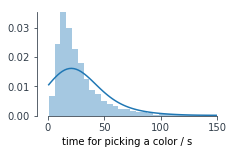

In [36]:
fig, ax = plt.subplots(figsize=(2/golden_ratio,2))

sns.distplot(df['delta_t'].dt.total_seconds().dropna(), bins=800, ax=ax, kde_kws={'clip': (0.0, 200), 'cut': (0)})
plt.xlim(-10,150)
plt.xlabel('time for picking a color / s')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.savefig(os.path.join(RESULTS, 'time_taken.pdf'), bbox_inches='tight')

In [37]:
(df.sort_values(by='delta_t_seconds', ascending=False)['delta_t_seconds'] > 80).sum() / len(df) * 100

4.9176356589147288

In [38]:
(df.sort_values(by='delta_t_seconds', ascending=False)['delta_t_seconds'] < 5).sum() / len(df) * 100

2.5678294573643412

In [39]:
len(df)

4128

In [40]:
df = df[~((df['delta_t_seconds'] > 80) | (df['delta_t_seconds'] < 5))]

In [41]:
len(df)

3819

In [42]:
4128 - 3819

309

In [43]:
selected = []
for color in sorted(list(df_std['color_string'].astype("str").unique())):
    df_subset = df[df['color_string']==color]
    mean = df_std[df_std['color_string'] == color]['avg'].values[0]
    std = df_std[df_std['color_string'] == color]['std_weighted'].values[0]
    for i, row in df_subset.iterrows():
        r = row['r']
        g = row['g']
        b = row['b']
        
        z_r = np.abs(r-mean[0]) / (std * 0.299)
        z_g = np.abs(g-mean[1]) / (std * 0.587)
        z_b = np.abs(b-mean[2]) / (std * 0.587)
        
        if (z_r < 2.5) & (z_g < 2.5) & (z_b < 2.5):
            selected.append(row) 
    

In [44]:
df = pd.DataFrame(selected)

In [45]:
grouped_by_color =  df.groupby('color_string').median().sort_values(by='delta_t_seconds', ascending=True)

In [46]:
slow_colors = list(grouped_by_color[grouped_by_color['delta_t_seconds'] > 33.9].index)

In [47]:
fast_colors  = list(grouped_by_color[grouped_by_color['delta_t_seconds'] < 12.8].index)

In [48]:
df_fast_slow = df[df['color_string'].isin(slow_colors + fast_colors)].sort_values(by='delta_t_seconds')

In [49]:
colors_for_bar =  []

for c in slow_colors + fast_colors:
    df_subset = df[df['color_string'] == c]
    r = int(df_subset['r'].median())
    g = int(df_subset['g'].median())
    b = int(df_subset['b'].median())
    
    
    colors_for_bar.append(rgb_to_hex((r, g, b)))

In [50]:
fig, ax = plt.subplots(figsize=(4/golden_ratio,4))

sns.boxplot(x="color_string", y="delta_t_seconds", data=df_fast_slow, ax=ax, order=slow_colors + fast_colors, 
            palette=colors_for_bar)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.hlines(df['delta_t_seconds'].median(), -1, 7, ls='dotted')
ax.set_ylabel('time taken / s')
ax.set_xlabel('color string')

ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

fig.tight_layout()
plt.savefig(os.path.join(RESULTS, 'colors_time_extremes.pdf'), bbox_inches='tight')

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  if __name__ == '__main__':


## Get the RGBs

In [51]:
df_merged = df_std.merge(grouped_by_color, left_on='color_string', right_on='color_string')

In [94]:
from scipy import stats

stats.spearmanr(df_merged['delta_t_seconds'], df_merged['std'])

SpearmanrResult(correlation=0.03905540960114641, pvalue=0.625003951262741)

In [95]:
stats.spearmanr(df_merged['delta_t_seconds'], df_merged['std_weighted'])

SpearmanrResult(correlation=0.15752328636255075, pvalue=0.047365308634491947)

In [96]:
stats.spearmanr(df_merged['delta_t_seconds'], df_merged['delta_e'])

SpearmanrResult(correlation=0.13692082636732747, pvalue=0.085251140909098619)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  import sys
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  


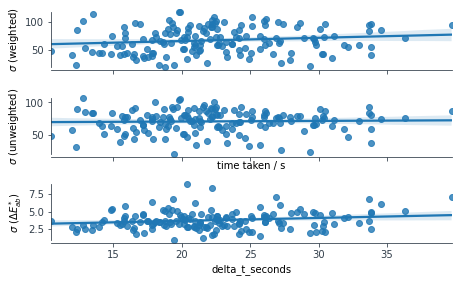

In [57]:
fig, ax = plt.subplots(3,1, figsize=(4/golden_ratio, 4), sharex=True)


for a in ax:
    a.spines['top'].set_color('none')
    a.spines['right'].set_color('none')
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)



sns.regplot(df_merged['delta_t_seconds'], df_merged['std_weighted'], ax=ax[0])
sns.regplot(df_merged['delta_t_seconds'], df_merged['std'], ax=ax[1])
sns.regplot(df_merged['delta_t_seconds'], df_merged['delta_e'], ax=ax[2])
ax[0].set_ylabel(r'$\sigma$ (weighted)')
ax[1].set_ylabel(r'$\sigma$ (unweighted)')
ax[2].set_ylabel(r'$\sigma$ ($\Delta E^*_{ab}$)')
ax[0].set_xlabel('')
ax[1].set_xlabel('time taken / s')

fig.tight_layout()
plt.savefig(os.path.join(RESULTS, 'std_time.pdf'), bbox_inches='tight')

(array([  4.,  19.,  39.,  41.,  33.,  12.,   5.,   4.,   0.,   2.]),
 array([ 0.92986886,  1.72877329,  2.52767771,  3.32658213,  4.12548655,
         4.92439097,  5.72329539,  6.52219981,  7.32110423,  8.12000865,
         8.91891307]),
 <a list of 10 Patch objects>)

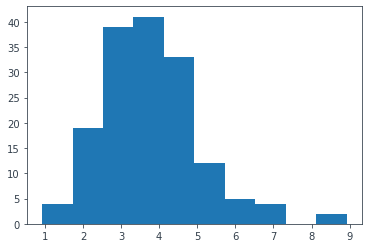

In [64]:
plt.hist(df_merged['delta_e'])

In [73]:
high_var_weighted = list(df_merged[df_merged['std_weighted'] > 103]['color_string'])
low_var_weighted = list(df_merged[df_merged['std_weighted'] < 33.4]['color_string'])
df_high_low_var_weighted = df_merged[df_merged['color_string'].isin(high_var_weighted + low_var_weighted)].sort_values(by='std_weighted')

In [74]:
high_var = list(df_merged[df_merged['std'] > 95]['color_string'])
low_var = list(df_merged[df_merged['std'] < 38.3]['color_string'])
df_high_low_var = df_merged[df_merged['color_string'].isin(high_var+ low_var)].sort_values(by='std')

In [86]:
high_var_deltae = list(df_merged[df_merged['delta_e'] > 6.5]['color_string'])
low_var_deltae = list(df_merged[df_merged['delta_e'] < 1.8]['color_string'])
df_high_low_var_deltae = df_merged[df_merged['color_string'].isin(high_var_deltae+ low_var_deltae)].sort_values(by='std')

In [87]:
colors_for_bar_weighted =  []

for c in high_var_weighted + low_var_weighted:
    df_subset = df[df['color_string'] == c]
    r = int(df_subset['r'].mean())
    g = int(df_subset['g'].mean())
    b = int(df_subset['b'].mean())
    
    colors_for_bar_weighted.append(rgb_to_hex((r, g, b)))

In [88]:
colors_for_bar =  []

for c in high_var + low_var:
    df_subset = df[df['color_string'] == c]
    r = int(df_subset['r'].mean())
    g = int(df_subset['g'].mean())
    b = int(df_subset['b'].mean())
    
    colors_for_bar.append(rgb_to_hex((r, g, b)))

In [89]:
colors_for_bar_deltae =  []

for c in high_var_deltae + low_var_deltae:
    df_subset = df[df['color_string'] == c]
    r = int(df_subset['r'].mean())
    g = int(df_subset['g'].mean())
    b = int(df_subset['b'].mean())
    
    colors_for_bar_deltae.append(rgb_to_hex((r, g, b)))

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml2/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


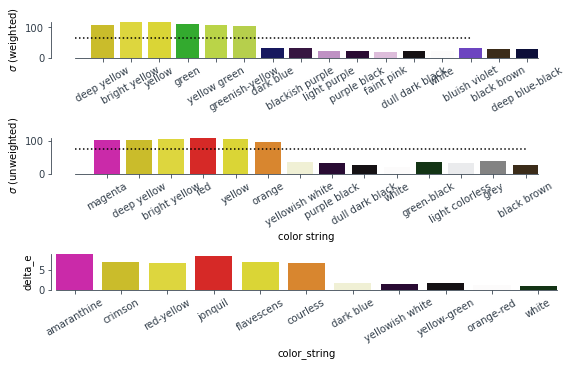

In [90]:
fig, ax = plt.subplots(3,1, figsize=(5/golden_ratio, 5))

sns.barplot(x="color_string", y="std_weighted", data=df_high_low_var_weighted, ax=ax[0], 
            order=high_var_weighted + low_var_weighted, palette=colors_for_bar_weighted, 
           )

sns.barplot(x="color_string", y="std", data=df_high_low_var,ax=ax[1], 
            order=high_var+ low_var, palette=colors_for_bar 
           )


sns.barplot(x="color_string", y="delta_e", data=df_high_low_var_deltae,ax=ax[2], 
            order=high_var_deltae+ low_var_deltae, palette=colors_for_bar 
           )

for a in ax:
    a.spines['top'].set_color('none')
    a.spines['right'].set_color('none')
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    a.set_xticklabels(a.get_xticklabels(),rotation=30)

ax[0].hlines(df_merged['std_weighted'].median(), -1, 13, ls='dotted')
ax[1].hlines(df_merged['std'].median(), -1, 13, ls='dotted')

ax[0].set_ylabel(r'$\sigma$ (weighted)')
ax[1].set_ylabel(r'$\sigma$ (unweighted)')
ax[1].set_xlabel('color string')
ax[0].set_xlabel('')

fig.tight_layout()
plt.savefig(os.path.join(RESULTS, 'colors_var_extremes.pdf'), bbox_inches='tight')

In [80]:
import collections
color_dict = collections.OrderedDict()

for color in sorted(list(df['color_string'].astype("str").unique())):
    df_subset = df[df['color_string']==color]
    colors = []
    for i, row in df_subset.iterrows():
        colors.append(row[['r', 'g', 'b']].to_list())
    color_dict[color] = colors

In [43]:
import pickle
with open('../data/augment_dict.pkl', 'wb') as fh: 
    pickle.dump(color_dict, fh)

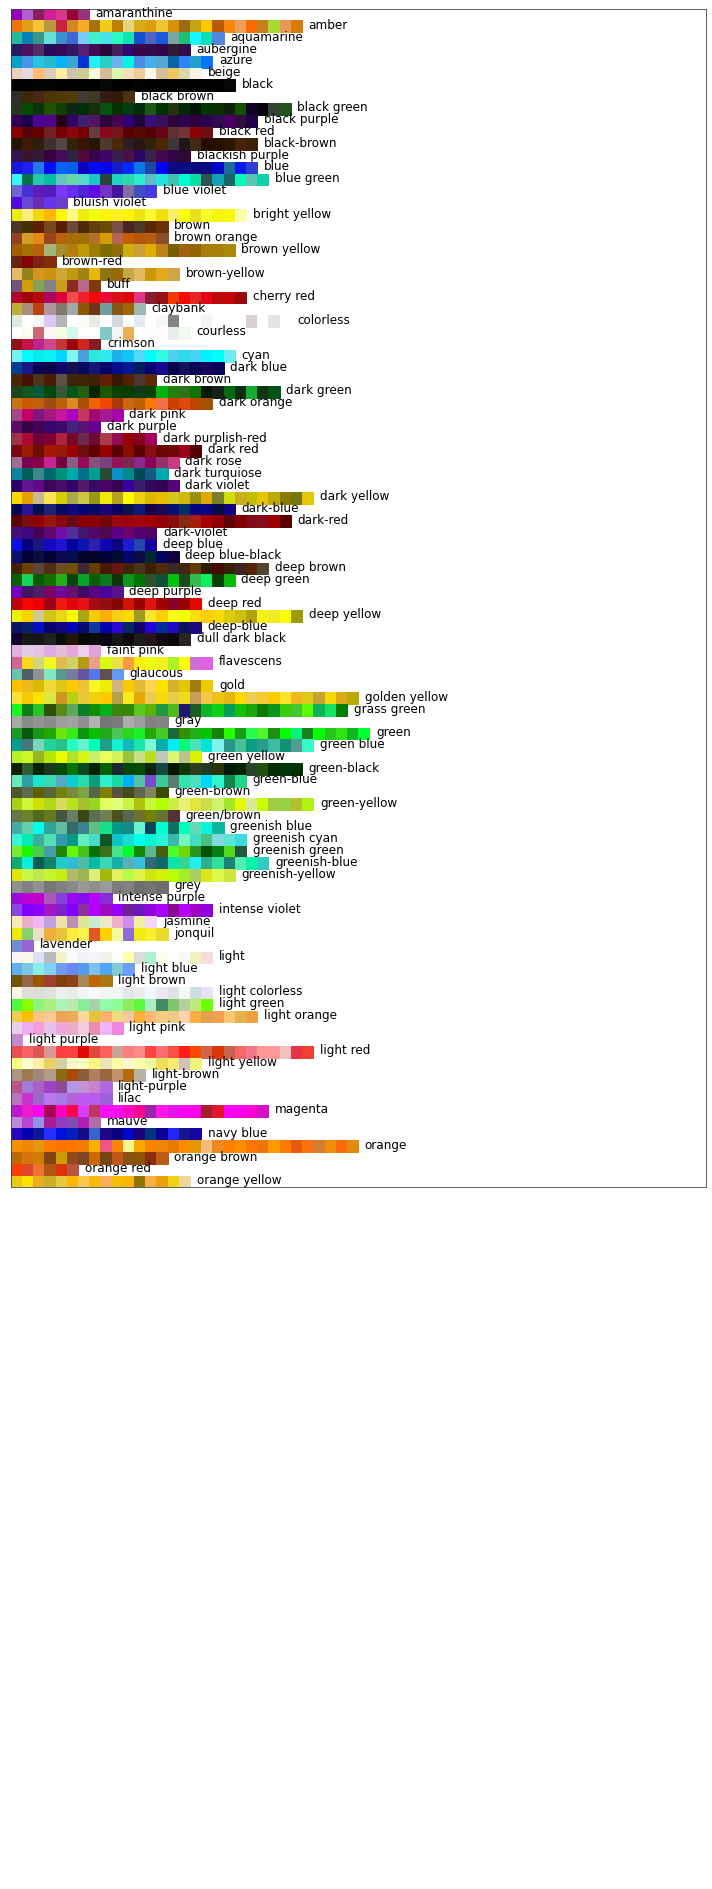

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import math
import matplotlib
    
width= 10
height= 30

fig = plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)

ratio = 1.0 / 3.0
x_count = 62
y_count = 100
x = 0
y = y_count - 1
w = 1 / x_count
h = 1 / y_count
counter = 0

for k, v in color_dict.items():

    for color in v: 
        c = rgb_to_hex((int(color[0]),int(color[1]),int(color[2])))
        pos = (x / x_count, y / y_count)
        ax.add_patch(patches.Rectangle(pos, w, h, color=c))
        x += 1
    pos = (x / x_count + 1/x_count / 1.7, y / y_count + 1/y_count / 3)
    ax.add_patch(patches.Rectangle(pos, w, h, color='white',  alpha=0))
    ax.annotate(k, xy=pos,fontsize=12)
    x = 0
    y -= 1
    counter += 1
    
plt.yticks([])
plt.xticks([])
fig.tight_layout()
#fig.savefig(os.path.join(RESULTS, 'all_responses_2.pdf'), bbox_inches='tight')

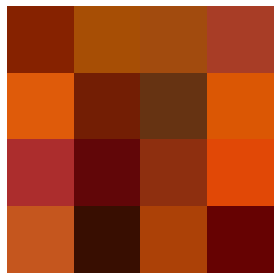

In [100]:
import random

color = 'red brown'
plt.imshow(np.array(random.sample(color_dict[color],16)).reshape(4,4,3))
ax = plt.gca()
ax.set_axis_off()
plt.tight_layout()

plt.savefig('{}_sample.pdf'.format(color), bbox_inches='tight')

In [122]:
np.percentile(color_dict['pale yellow'],0.5, axis=0)

array([ 121.69,   60.02,   12.67])

In [123]:
np.percentile(color_dict['pale yellow'],0.1, axis=0)

array([ 102.738,   28.004,    7.334])

In [124]:
np.percentile(color_dict['pale yellow'],0.9, axis=0)

array([ 140.642,   92.036,   18.006])

In [38]:
from colour.plotting import plot_RGB_scatter, plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931

In [39]:
magenta = df[df['color_string'] == 'magenta'][['r', 'g', 'b']].values

In [40]:
fig = plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(colorless, scatter_parameters={'marker': '*', 
                                                                                    'c': 'k', 
                                                                                    'label': 'colorless'}, standalone=False)

fig[0].tight_layout()
fig[0].axes[0].get_legend().remove()
fig[0].axes[0].set_title('')
fig[0].savefig(os.path.join(RESULTS, 'colorless.pdf'), bbox_inches='tight')

NameError: name 'colorless' is not defined

In [105]:
color = df[df['color_string'] == 'magenta'][['r', 'g', 'b']].values

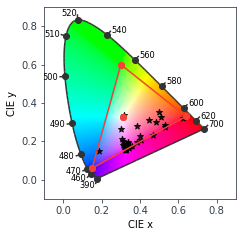

In [106]:
fig = plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(magenta, scatter_parameters={'marker': '*', 
                                                                                    'c': 'k', 
                                                                                    'label': 'magenta', }, standalone=False)

fig[0].tight_layout()
fig[0].axes[0].get_legend().remove()
fig[0].axes[0].set_title('')
fig[0].savefig(os.path.join(RESULTS, 'magenta.pdf'), bbox_inches='tight')

## Compare to the xkcd results

xkcd ran a survey to name rgb colors https://xkcd.com/color/rgb/, i.e. the reverse thing of what we actually did. 


In [34]:
xkcd_data = pd.read_csv('../data/xkcd.tsv', sep='\t', names=['name', 'hex', 'Blub'])

In [35]:
xkcd_data.head()

name      hex  Blub
0        cloudy blue  #acc2d9   NaN
1  dark pastel green  #56ae57   NaN
2               dust  #b2996e   NaN
3      electric lime  #a8ff04   NaN
4        fresh green  #69d84f   NaN

In [36]:
xkcd_data = xkcd_data[['name', 'hex']]

In [37]:
rs_xkcd, gs_xkcs, bs_xkcd = get_rgb_lists(xkcd_data)

In [38]:
xkcd_data['r'] = rs_xkcd
xkcd_data['g'] = gs_xkcs
xkcd_data['b'] = bs_xkcd

In [39]:
xkcd_data.head()

name      hex    r    g    b
0        cloudy blue  #acc2d9  172  194  217
1  dark pastel green  #56ae57   86  174   87
2               dust  #b2996e  178  153  110
3      electric lime  #a8ff04  168  255    4
4        fresh green  #69d84f  105  216   79

### First, lets do the easiest thing and just look at those that directly overlap

In [40]:
len(df['color_string'].unique())

158

In [21]:
colors_overlap = set(colors_clean) & set(xkcd_data['name'].unique())

NameError: name 'xkcd_data' is not defined

In [42]:
len(colors_overlap)

100

Seems not too bad for a first analysis, let's see what is in there.

In [43]:
df_grouped_by_color = df.groupby('clean_name').agg('mean')

In [44]:
merged_color = df_grouped_by_color.merge(xkcd_data, left_on='clean_name', right_on='name')

In [45]:
merged_color

delta_t_seconds         r_x         g_x         b_x             name  \
0         37.077902  215.692308  148.692308   32.692308            amber   
1         28.135978   53.947368  174.736842  196.105263       aquamarine   
2         27.011446   57.250000   16.687500   88.062500        aubergine   
3         24.342597   41.111111  163.888889  222.000000            azure   
4         26.217955  231.117647  215.352941  173.352941            beige   
..              ...         ...         ...         ...              ...   
93        23.081576  245.600000  238.900000   27.966667           yellow   
94        27.566455  197.575758  233.424242   52.363636     yellow green   
95        29.123289  240.681818  177.181818   24.727273    yellow orange   
96        25.357761  229.521739  223.782609   97.565217        yellowish   
97        27.693896  183.115385  225.538462   66.807692  yellowish green   

        hex  r_y  g_y  b_y  
0   #feb308  254  179    8  
1   #04d8b2    4  216  178  
2   #3d0734   61    7   52  
3   #069af3    6  154  243  
4   #e6daa6  230  218  166  
..      ...  ...  ...  ...  
93  #ffff14  255  255   20  
94  #c0fb2d  192  251   45  
95  #fcb001  252  176    1  
96  #faee66  250  238  102  
97  #b0dd16  176  221   22  

[98 rows x 9 columns]

In [51]:
survey = merged_color[['r_x', 'g_x', 'b_x']].values

xkcd = merged_color[['r_y', 'g_y', 'b_y']].values

In [46]:
hex_mean = [rgb_to_hex((int(c[0]),int(c[1]),int(c[2]))) for c in merged_color[['r_x', 'g_x', 'b_x']].values]

In [47]:
merged_color['hex_survey'] = hex_mean

In [48]:
from colorml.utils.utils import pairwise_delta_es

In [54]:
distances = pairwise_delta_es(survey/255, xkcd/255)

In [55]:
np.mean(distances)

8.3943167216667636

In [56]:
np.median(distances)

6.8517695474613314

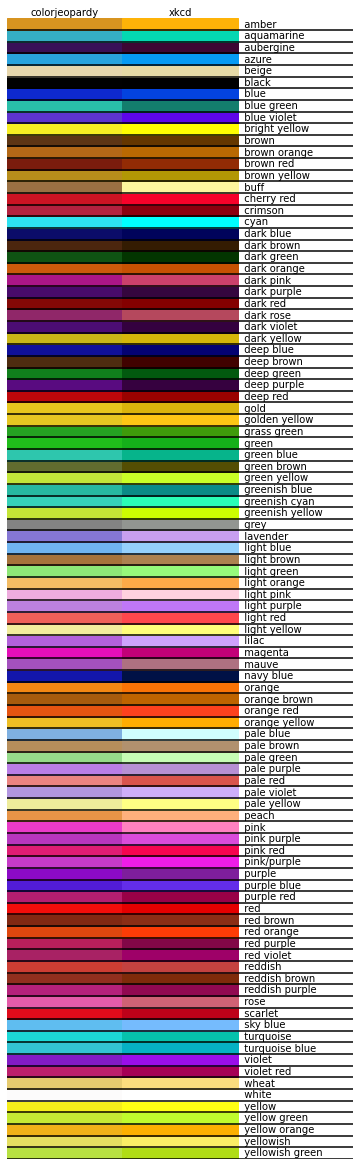

In [888]:
# code from https://matplotlib.org/tutorials/colors/colors.html
import matplotlib.patches as mpatch

fig = plt.figure(figsize=[4.8, 16])
ax = fig.add_axes([0, 0, 1, 1])

for j, n in enumerate(sorted(merged_color['name'], reverse=True)):
    r1 = mpatch.Rectangle((0, j), 1, 1, color=merged_color[merged_color['name']==n]['hex_survey'].values[0])
    r2 = mpatch.Rectangle((1, j), 1, 1, color=merged_color[merged_color['name']==n]['hex'].values[0])
    txt = ax.text(2, j+.5, '  ' + n, va='center', fontsize=10)


    ax.add_patch(r1)
    ax.add_patch(r2)
    ax.axhline(j, color='k')

ax.text(.5, j + 1.5, 'colorjeopardy', ha='center', va='center')
ax.text(1.5, j + 1.5, 'xkcd', ha='center', va='center')
ax.set_xlim(0, 3)
ax.set_ylim(0, j + 2)
ax.axis('off')

fig.tight_layout()
fig.savefig(os.path.join(RESULTS, 'mean_rgb_vs_xkcd.pdf'), bbox_inches='tight')

Seems that we have generally reasonable results. 

#### Now, let's check where the xkcd colors lie in the distributions

In [889]:
merged_color[merged_color['name']==n]

delta_t_seconds         r_x         g_x        b_x   name      hex  r_y  \
0        37.077902  215.692308  148.692308  32.692308  amber  #feb308  254   

   g_y  b_y hex_survey  
0  179    8    #d79420

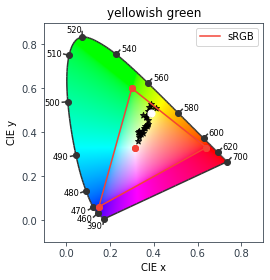

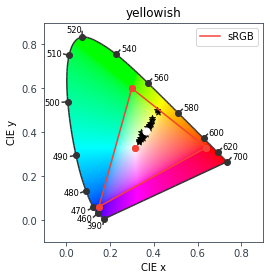

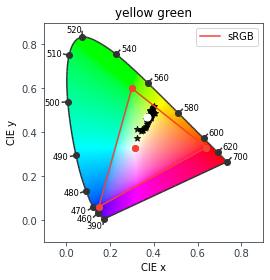

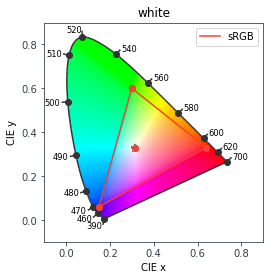

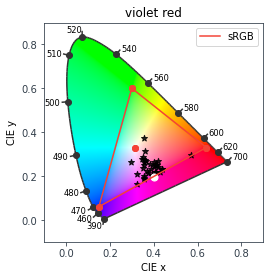

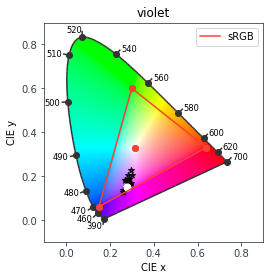

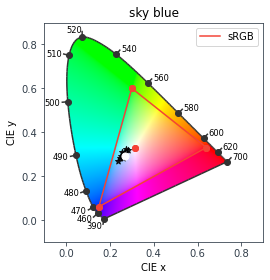

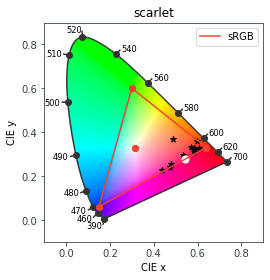

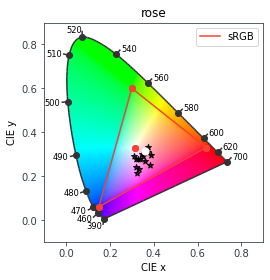

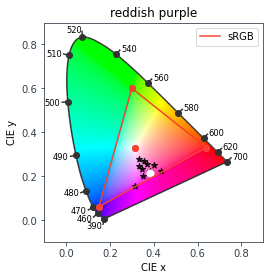

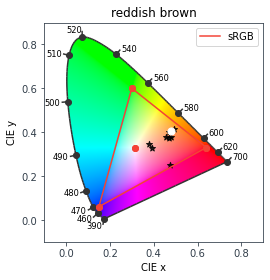

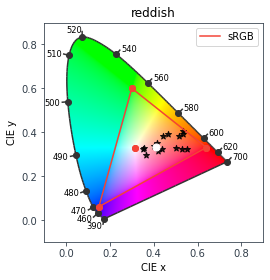

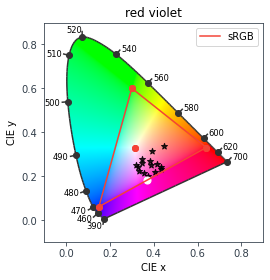

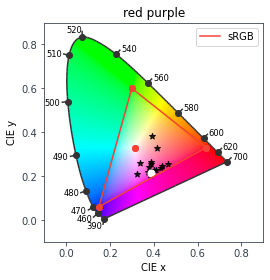

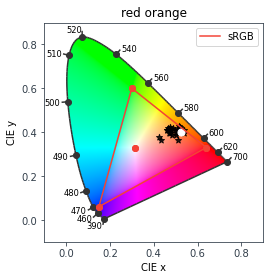

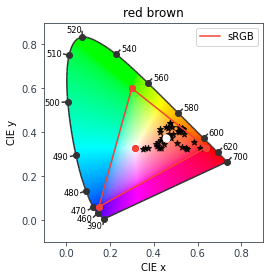

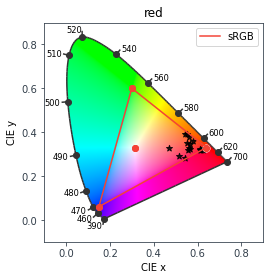

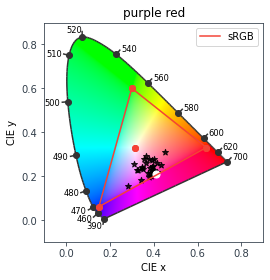

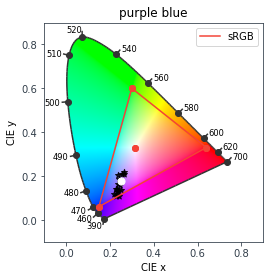

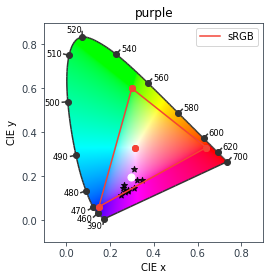

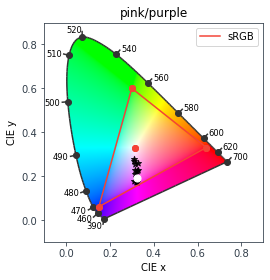

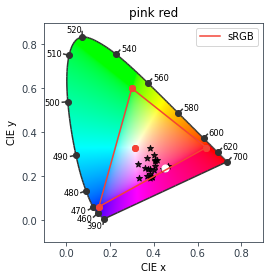

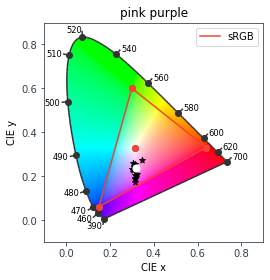

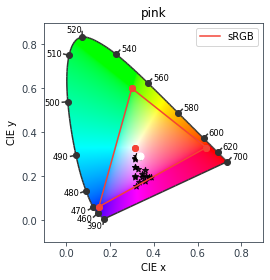

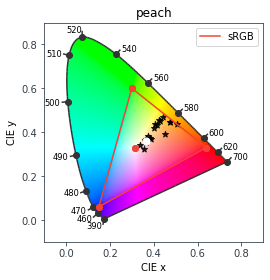

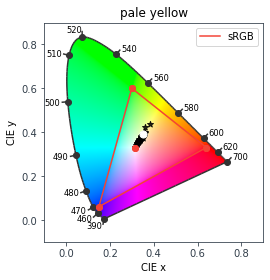

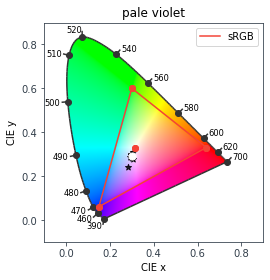

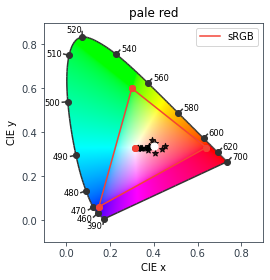

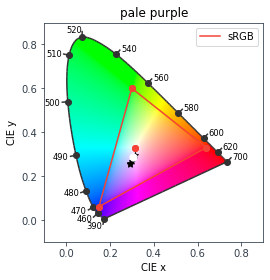

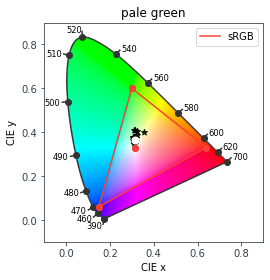

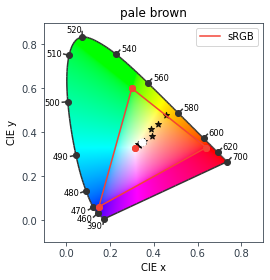

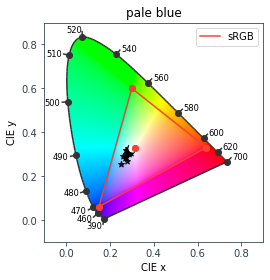

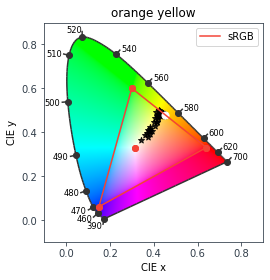

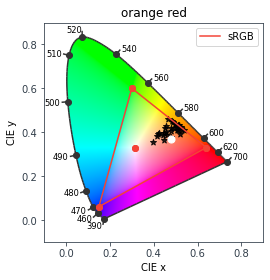

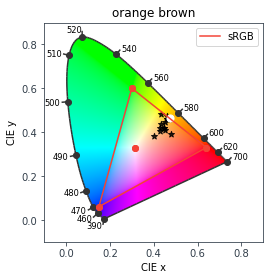

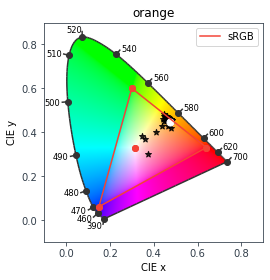

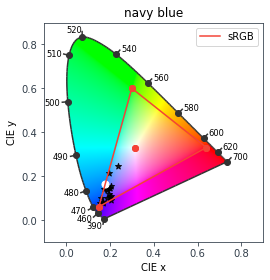

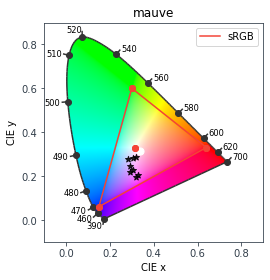

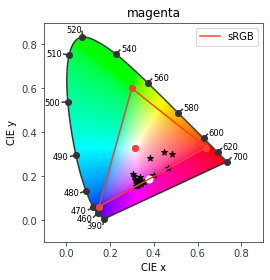

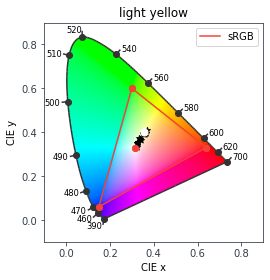

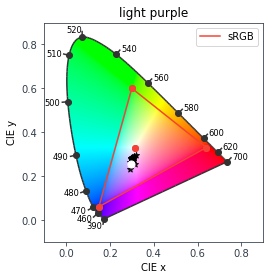

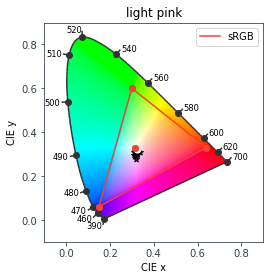

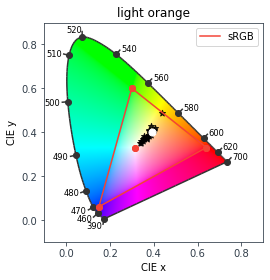

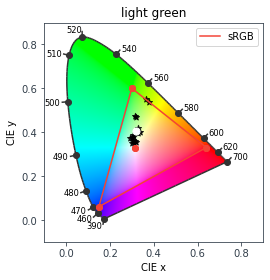

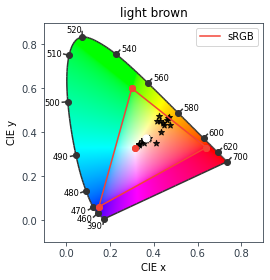

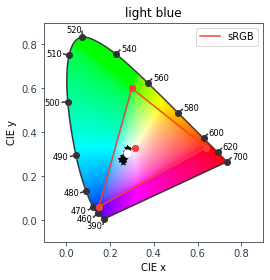

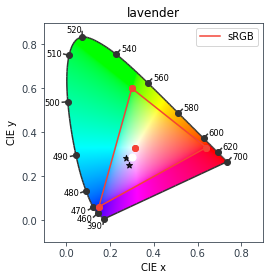

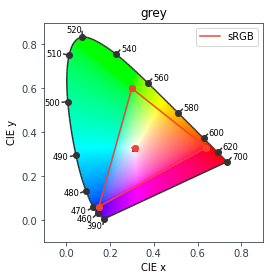

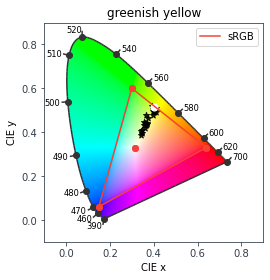

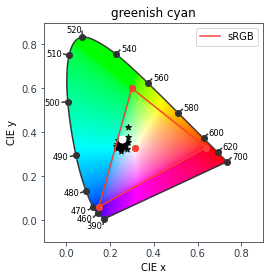

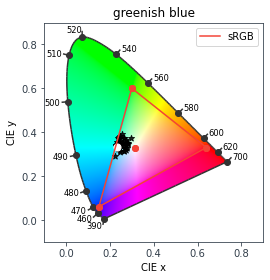

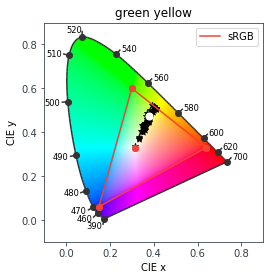

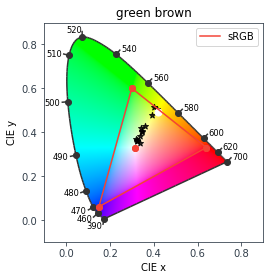

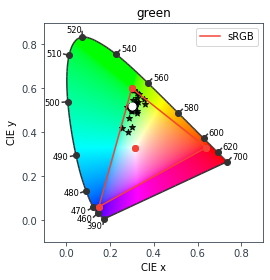

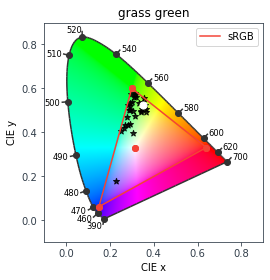

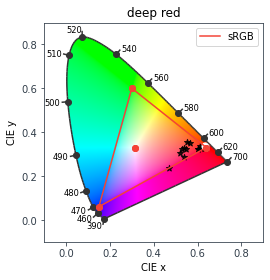

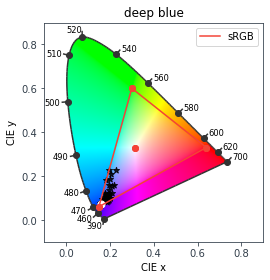

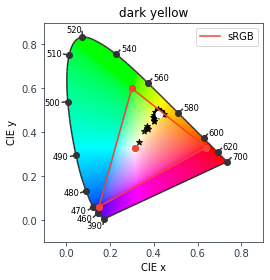

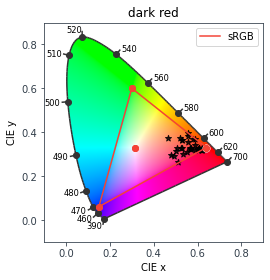

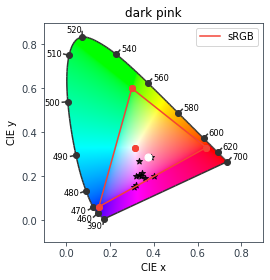

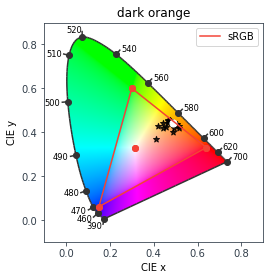

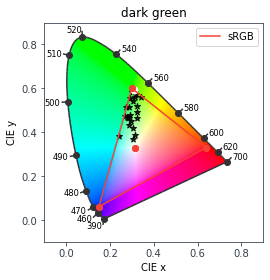

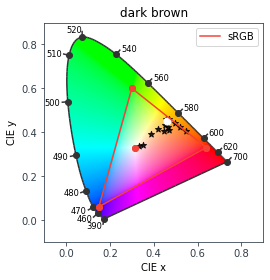

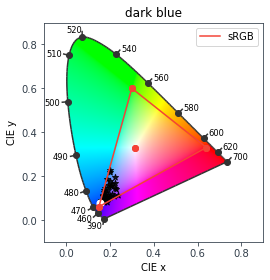

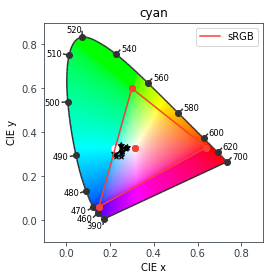

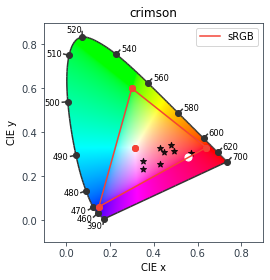

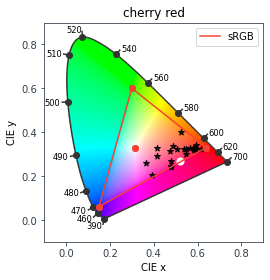

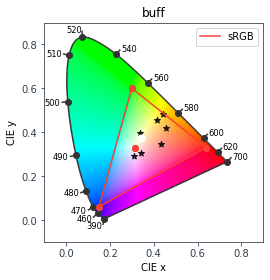

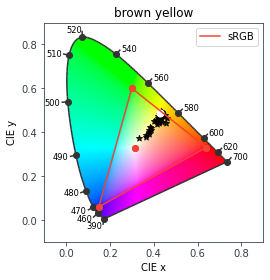

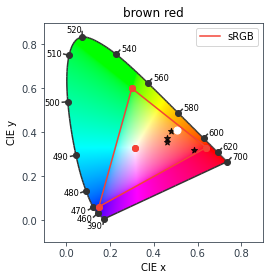

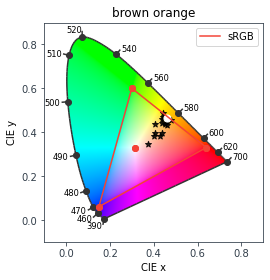

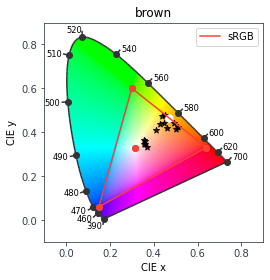

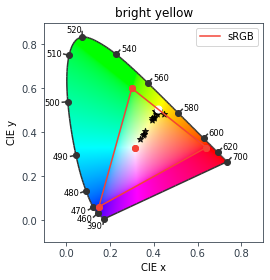

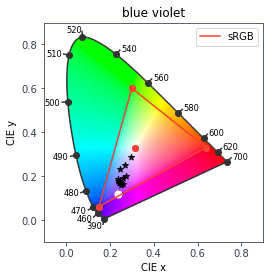

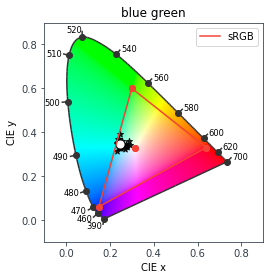

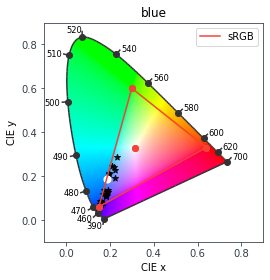

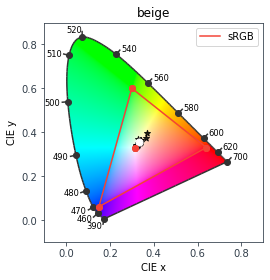

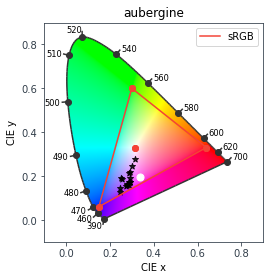

In [890]:
from colour.models import RGB_to_XYZ, XYZ_to_xy
from colour.plotting import filter_RGB_colourspaces
from colour.utilities import first_item

colourspace = first_item(filter_RGB_colourspaces('sRGB').values())


for j, n in enumerate(sorted(merged_color['name'], reverse=True)):
    try:
        colors = df[df['clean_name'] == n][['r', 'g', 'b']].values
        xkcd_color = merged_color[merged_color['name']==n]
        XYZ = RGB_to_XYZ(xkcd_color[['r_y', 'g_y', 'b_y']], colourspace.whitepoint, colourspace.whitepoint,
                            colourspace.RGB_to_XYZ_matrix)
        ij = XYZ_to_xy(XYZ, colourspace.whitepoint)

        fig = plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(colors, scatter_parameters={'marker': '*', 
                                                                                            'c': 'k', }, standalone=False)
        fig[0].axes[0].scatter(ij[:, 0], ij[:, 1], c='white', s=50)
        fig[0].axes[0].set_title(n)
        fig[0].savefig(os.path.join(RESULTS, 'maps', n.replace(' ', "_").replace('/', '_') + '.pdf'), bbox_inches='tight')
    except Exception as e:
        print(e)

Some lessons learned: 
- for some colors like blue green the variance in our survey is really low and the agreement with xkcd is really high
- for others, like deep brown the survey seems to be quite off from the xkcd result. The perception varies here really a lot. 
- Typically, I find the variance to be high when xkcd does not agree with our results
- we still need to remove some outliers.
- especially if a color is at the border of sRGB in xkcd we have a higher variance (e.g., deep blue, dark red)
- there might be some linguistic issues (e.g., the high variance for crimson)

## Filtering

In [22]:
df.head()

color_string      hex           starttime                 time_stamp  \
0   pale green  #05491e 2020-02-10 16:10:09 2020-02-10 16:10:17.358811   
1    pale blue  #759eea 2020-02-10 16:10:17 2020-02-10 16:10:25.771700   
2  amaranthine  #cc380b 2020-02-10 16:10:25 2020-02-10 16:10:45.384875   
3      magenta  #bd18ca 2020-02-10 16:10:45 2020-02-10 16:11:01.010912   
4   dark brown  #732e02 2020-02-10 16:11:01 2020-02-10 16:11:13.608265   

          delta_t  delta_t_seconds   clean_name    r    g    b  
0 00:00:08.358811         8.358811   pale green    5   73   30  
1 00:00:08.771700         8.771700    pale blue  117  158  234  
2 00:00:20.384875        20.384875  amaranthine  204   56   11  
3 00:00:16.010912        16.010912      magenta  189   24  202  
4 00:00:12.608265        12.608265   dark brown  115   46    2

## Let's redo the analysis with the filtered data.

In [893]:
df_grouped_by_color = df.groupby('clean_name').agg('median')
merged_color = df_grouped_by_color.merge(xkcd_data, left_on='clean_name', right_on='name')
hex_mean = [rgb_to_hex((int(c[0]),int(c[1]),int(c[2]))) for c in merged_color[['r_x', 'g_x', 'b_x']].values]
merged_color['hex_survey'] = hex_mean

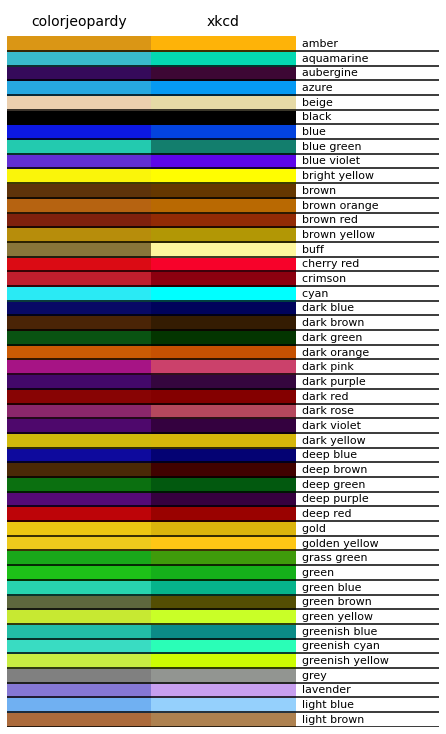

In [923]:
# code from https://matplotlib.org/tutorials/colors/colors.html
import matplotlib.patches as mpatch

fig = plt.figure(figsize=[6, 10])
ax = fig.add_axes([0, 0, 1, 1])
counter = 0
for j, n in enumerate(sorted(merged_color['name'], reverse=True)):
    if j > 50:
        r1 = mpatch.Rectangle((0, counter), 1, 1, color=merged_color[merged_color['name']==n]['hex_survey'].values[0])
        r2 = mpatch.Rectangle((1, counter), 1, 1, color=merged_color[merged_color['name']==n]['hex'].values[0])
        txt = ax.text(2, counter+.5, '  ' + n, va='center', fontsize=11)


        ax.add_patch(r1)
        ax.add_patch(r2)
        ax.axhline(counter, color='k')
        counter += 1

ax.text(.5, counter + 1, 'colorjeopardy', ha='center', va='center', fontsize=14)
ax.text(1.5, counter + 1, 'xkcd', ha='center', va='center', fontsize=14)
ax.set_xlim(0, 3)
ax.set_ylim(0, counter + 2)
ax.axis('off')

fig.tight_layout()
fig.savefig(os.path.join(RESULTS, 'median_rgb_vs_xkcd_cleaned_0.pdf'), bbox_inches='tight')

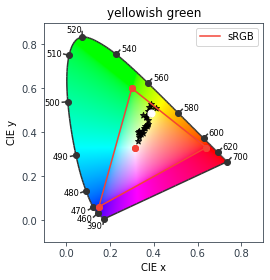

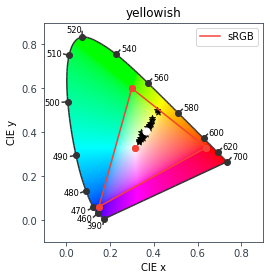

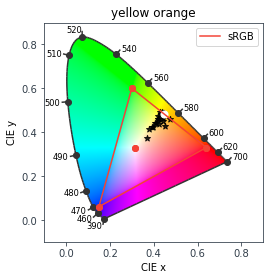

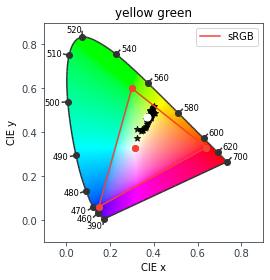

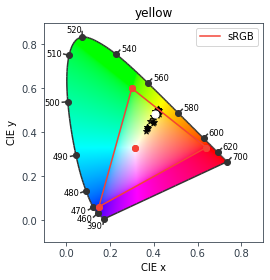

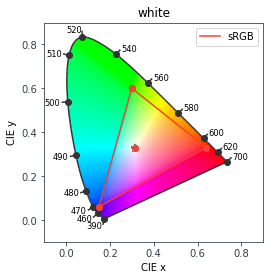

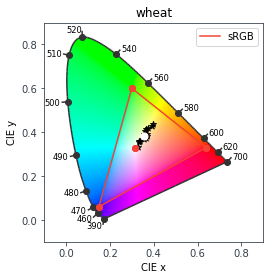

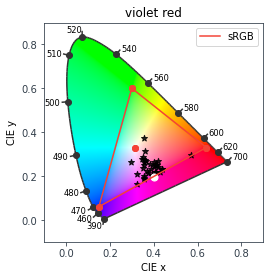

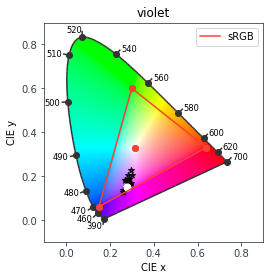

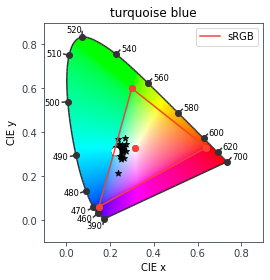

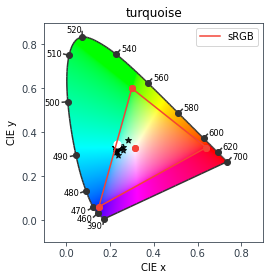

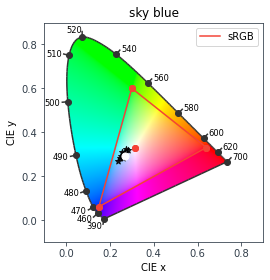

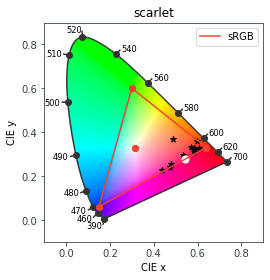

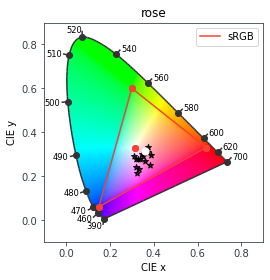

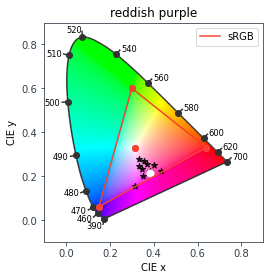

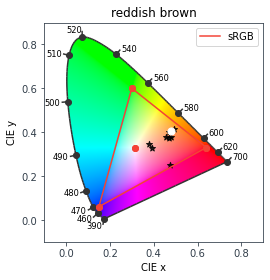

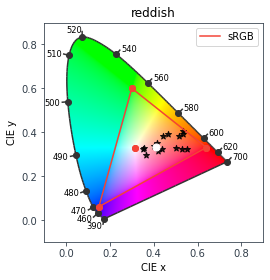

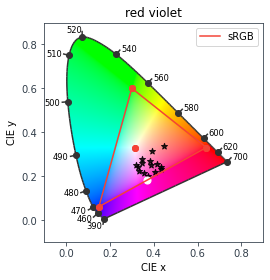

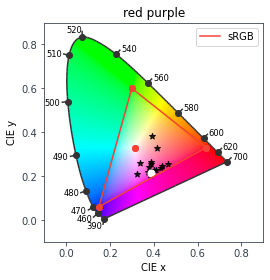

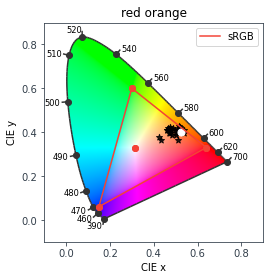

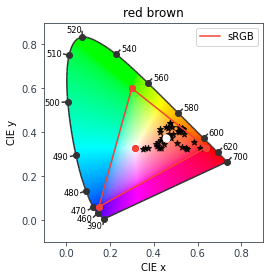

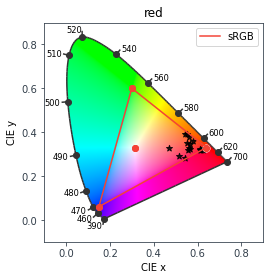

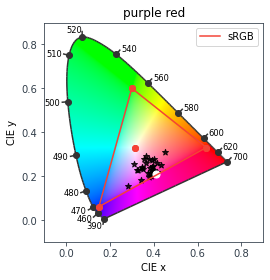

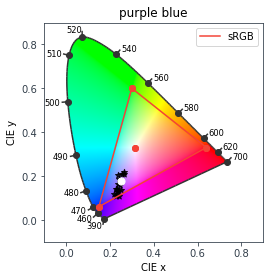

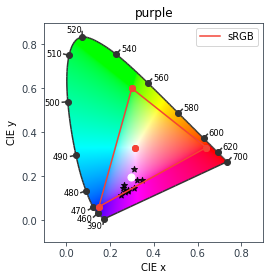

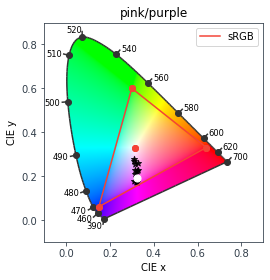

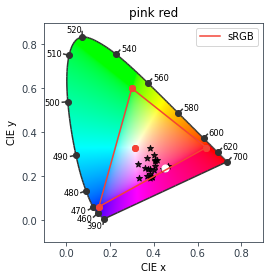

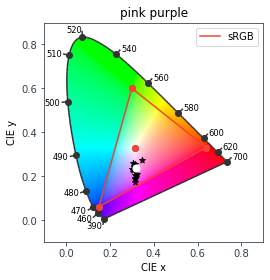

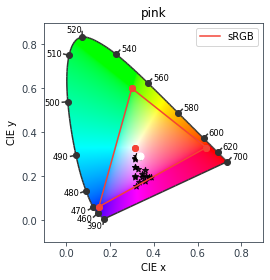

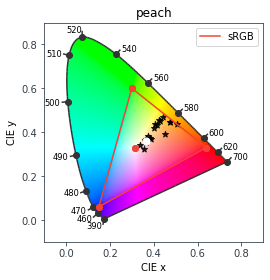

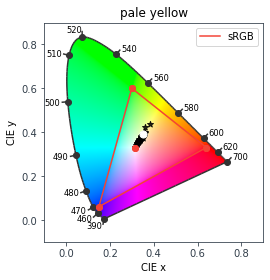

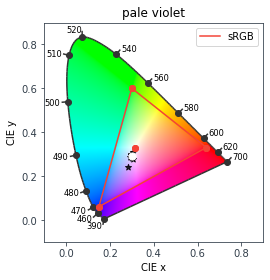

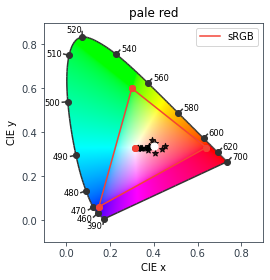

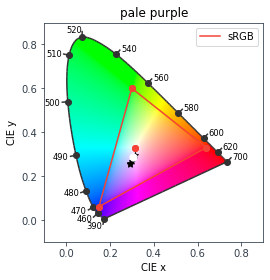

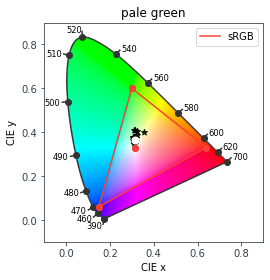

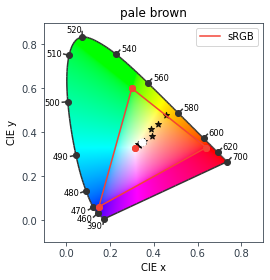

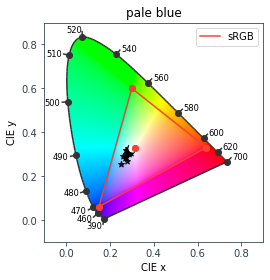

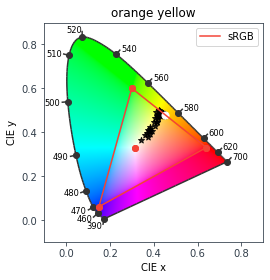

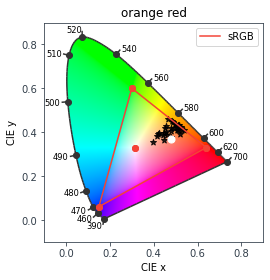

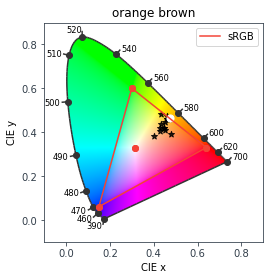

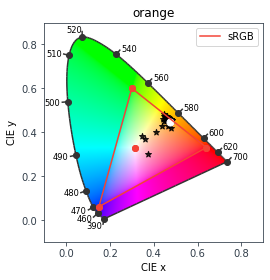

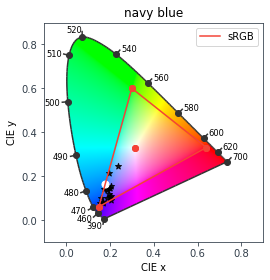

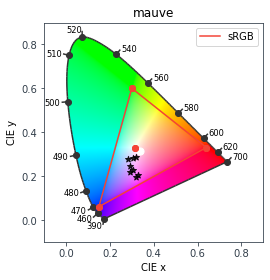

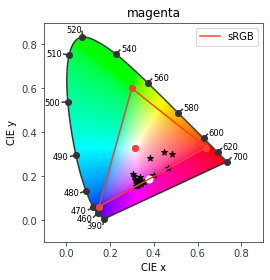

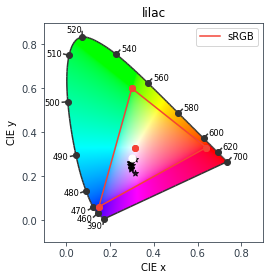

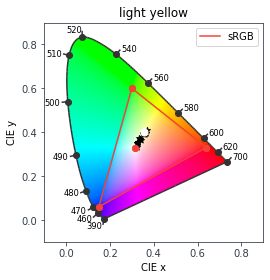

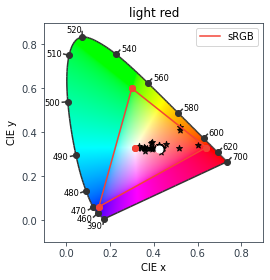

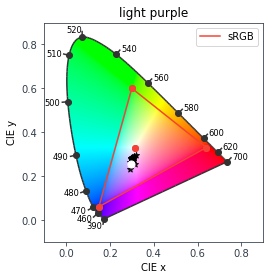

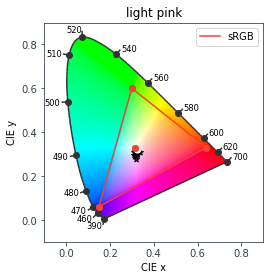

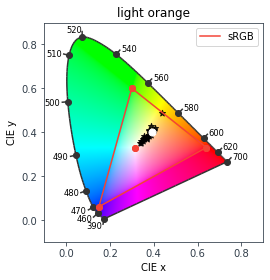

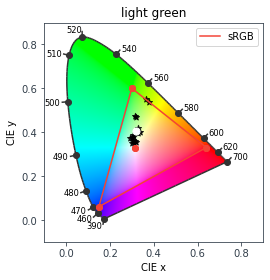

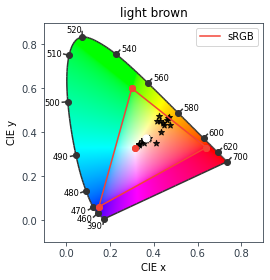

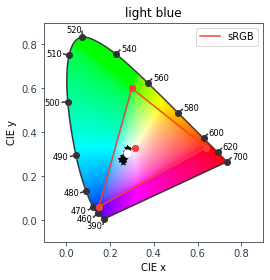

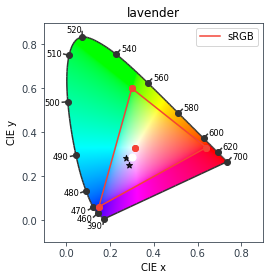

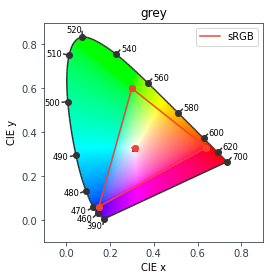

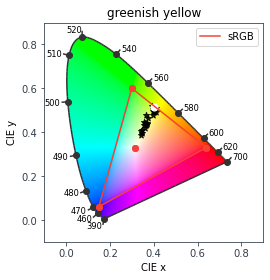

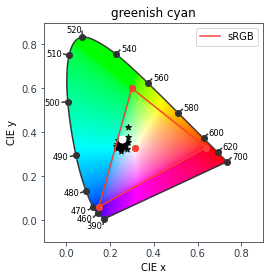

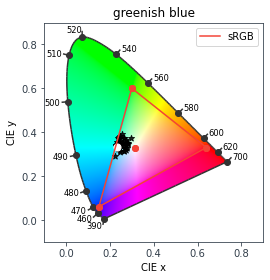

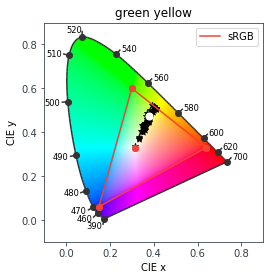

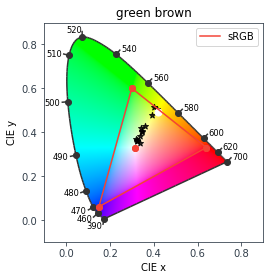

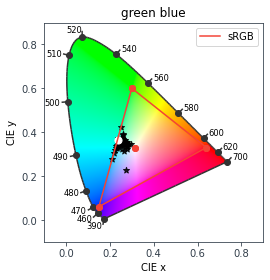

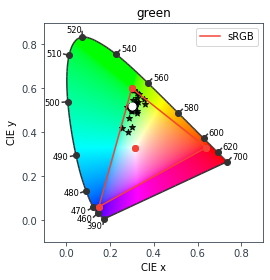

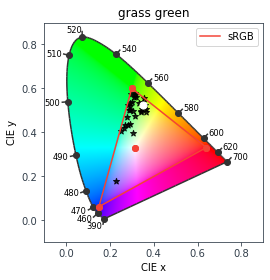

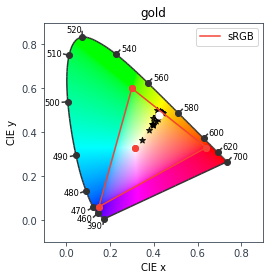

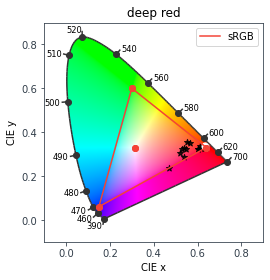

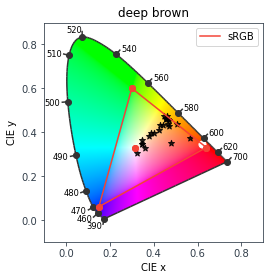

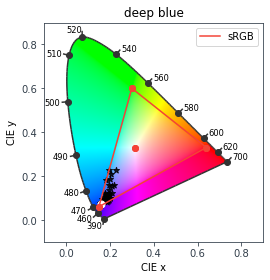

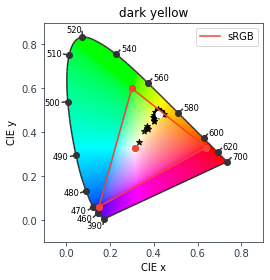

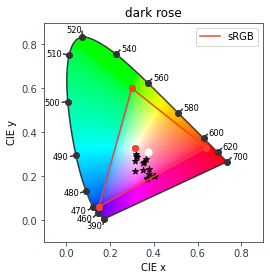

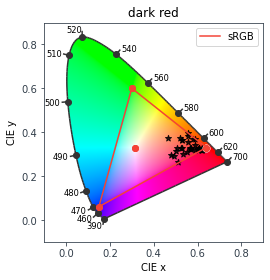

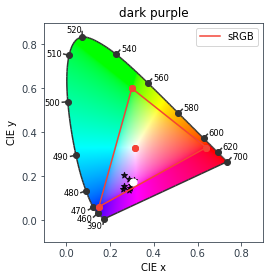

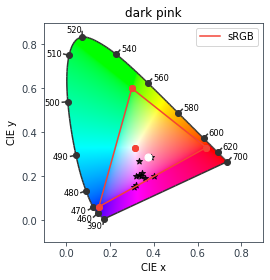

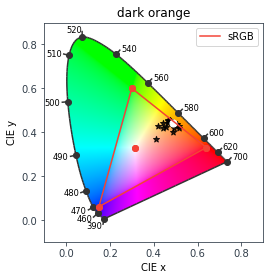

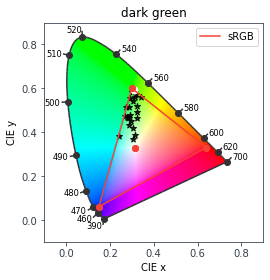

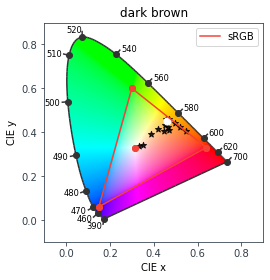

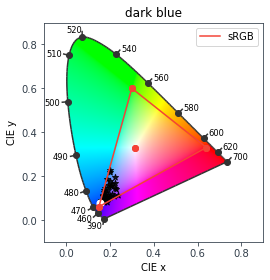

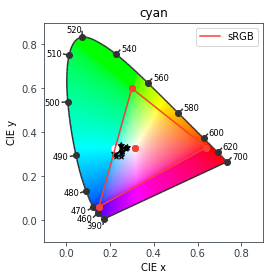

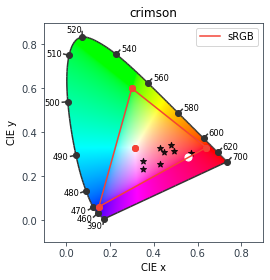

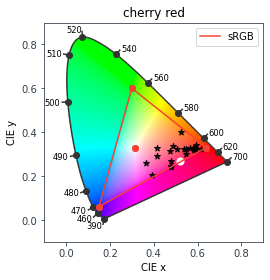

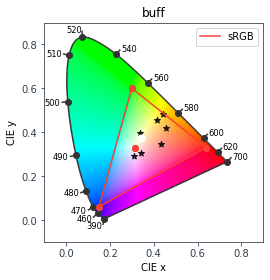

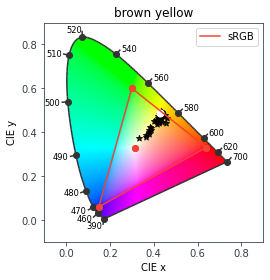

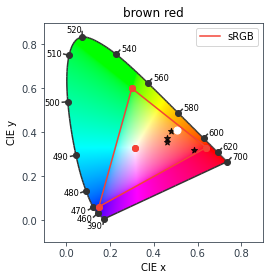

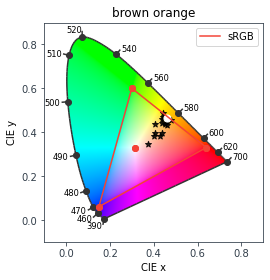

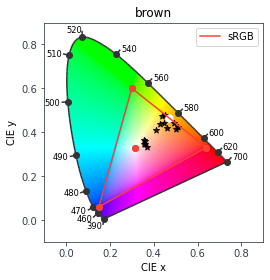

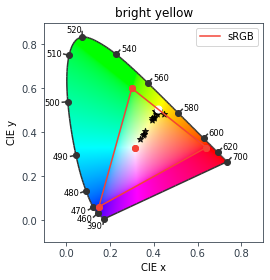

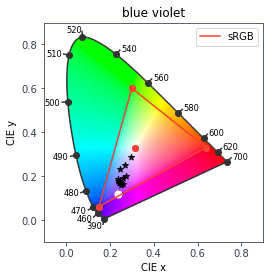

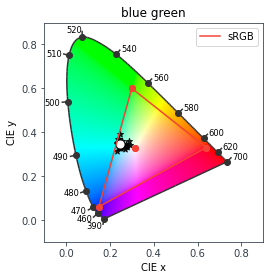

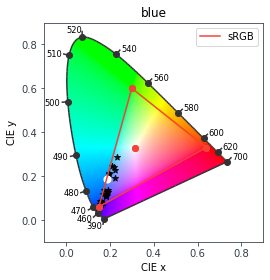

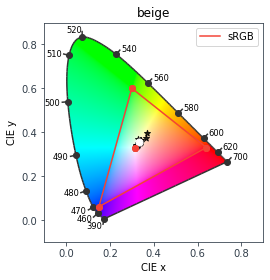

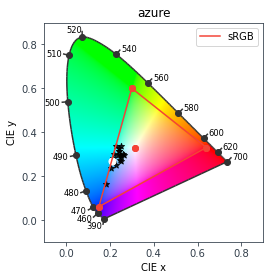

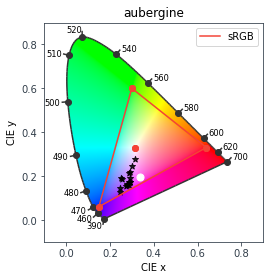

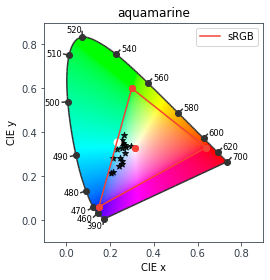

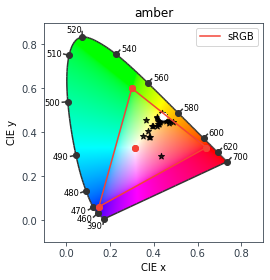

In [892]:
from colour.models import RGB_to_XYZ, XYZ_to_xy
from colour.plotting import filter_RGB_colourspaces
from colour.utilities import first_item

colourspace = first_item(filter_RGB_colourspaces('sRGB').values())


for j, n in enumerate(sorted(merged_color['name'], reverse=True)):
    try:
        colors = df[df['clean_name'] == n][['r', 'g', 'b']].values
        xkcd_color = merged_color[merged_color['name']==n]
        XYZ = RGB_to_XYZ(xkcd_color[['r_y', 'g_y', 'b_y']], colourspace.whitepoint, colourspace.whitepoint,
                            colourspace.RGB_to_XYZ_matrix)
        ij = XYZ_to_xy(XYZ, colourspace.whitepoint)

        fig = plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931(colors, scatter_parameters={'marker': '*', 
                                                                                            'c': 'k', }, standalone=False)
        fig[0].axes[0].scatter(ij[:, 0], ij[:, 1], c='white', s=50)
        fig[0].axes[0].set_title(n)
        fig[0].savefig(os.path.join(RESULTS, 'maps', 'after_clean', n.replace(' ', "_").replace('/', '_') + '.pdf'), bbox_inches='tight')
    except Exception as e:
        print(e)

In [133]:
df.to_csv('../data/cleaned_survey.csv', index=False)

In [134]:
df.groupby('color_string').agg('mean').to_csv('../data/cleaned_survey_unweighted_mean.csv')

In [135]:
df.groupby('color_string').agg('median').to_csv('../data/cleaned_survey_unweighted_median.csv')